In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from utils import *

path = "/Users/peter/Work/radiography/data/"
path_sim = "/Users/peter/Work/semiempirical_transparency/out/"
outfile = "/Users/peter/Work/semiempirical_transparency/paper/figs/"

H = "10"
L = "6"
H_twiddle = "9.7"
L_twiddle = "6.3"

### Loading simulated parameters

In [2]:
phi_H = np.load(path + "phi_%sMeV_10.npy" % H)
phi_L = np.load(path + "phi_%sMeV_10.npy" % L)
phi_H_twiddle = np.load(path + "phi_%sMeV_10.npy" % H_twiddle)
phi_L_twiddle = np.load(path + "phi_%sMeV_10.npy" % L_twiddle)
 
D = np.load(path + "D_10.npy")
E = np.load(path + "E_10.npy")
D_twiddle = approxDetectorResponse(E)

lmbdaRange = np.linspace(0, 500, 101)
zRange = np.arange(1, 101)
Z_plot = np.array([1, 13, 26, 47, 64, 82, 92])
mu_tot = calcMu_tot(E, zRange)
mu_PE = calcMu_PE(E, zRange)
mu_CS = calcMu_CS(E, zRange)
mu_PP = calcMu_PP(E, zRange)
    
norm = mpl.colors.Normalize(vmin=zRange[0], vmax=zRange[-1])
colormap = mpl.colormaps["viridis"]
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
color = lambda Z: cmap.to_rgba(Z)
n = len(lmbdaRange)
xrange = [0, 10]
yrange = [-2, 0]
xticks = np.arange(11)
yticks = np.linspace(np.ceil(2*yrange[0])/2, np.floor(2*yrange[1])/2, int(2*(yrange[1] - yrange[0]) + 1))

### Adding Compound Materials

In [3]:
compound_material = {}
compound_Z = {}
compound_f = {}
compound_c = {}

compound_material[101] = "Polyethylene (CH2)"
compound_Z[101] = np.array([1, 6])
compound_f[101] = np.array([0.143711, 0.856289])
compound_c[101] = color(6)

compound_material[102] = "Silver Chloride (AgCl)"
compound_Z[102] = np.array([17, 47])
compound_f[102] = np.array([0.247368, 0.752632])
compound_c[102] = color(47)

compound_material[103] = "Uranium Oxide (UO2)"
compound_Z[103] = np.array([8, 92])
compound_f[103] = np.array([0.118502, 0.881498])
compound_c[103] = color(92)

### Loading simulated data

In [4]:
energies = np.array(["10", "6", "4", "9.7", "6.3", "5.7", "5.5"])
theta = np.arcsin(400 / 700)

### Calibration data
# lookup_alpha_calib = calcLookupTables("lookup_alpha_calib.npy", path_sim + "calib/", energies, theta, D, mu_tot, zRange)
lookup_alpha_calib = calcLookupTables("lookup_alpha_calib.npy")
Z_arr_calib, Z_vals_calib, Z_compound_calib, alpha_H_calib, alpha_L_calib, sigma_H_calib, sigma_L_calib, lmbda_H_calib, lmbda_L_calib = extractFromTables(lookup_alpha_calib, H, L)

### Test data
# lookup_alpha = calcLookupTables("lookup_alpha.npy", path_sim, energies, theta, D, mu_tot, zRange, compound_Z, compound_f)
lookup_alpha = calcLookupTables("lookup_alpha.npy")
Z_arr, Z_vals, Z_compound, alpha_H_arr, alpha_L_arr, sigma_H_arr, sigma_L_arr, lmbda_H_arr, lmbda_L_arr = extractFromTables(lookup_alpha, H, L)

### Results Summary

Minimum found at a = 1.1148, b=0.9600, c=0.9994 with a loss of 1.495e-11
Minimum found at a = 0.9453, b=0.9680, c=0.9980 with a loss of 5.569e-12
Minimum found at a = 1.0662, b=0.9792, c=1.0028 with a loss of 1.637e-12
Minimum found at a = 1.1271, b=1.0345, c=0.9078 with a loss of 1.483e-12


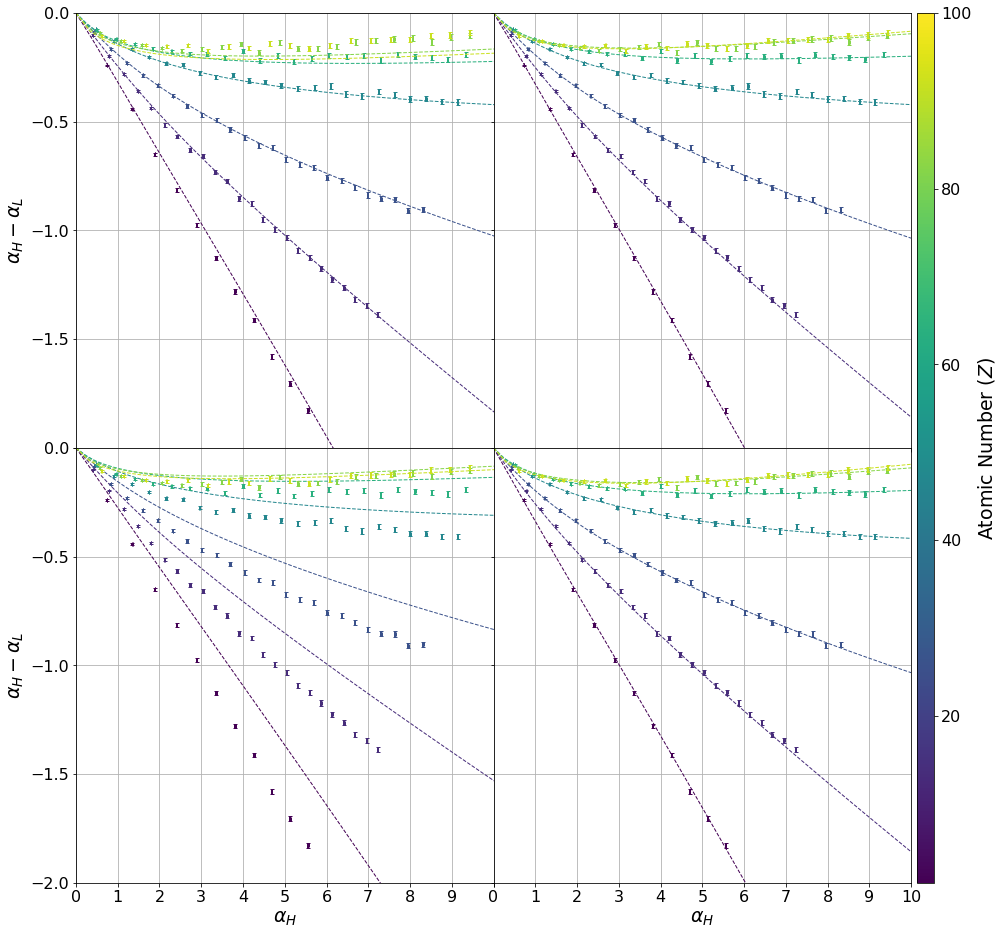

In [5]:
a_H, b_H, c_H = fitSemiempirical(alpha_H_calib, lmbda_H_calib, Z_arr_calib, phi_H, D, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
a_L, b_L, c_L = fitSemiempirical(alpha_L_calib, lmbda_L_calib, Z_arr_calib, phi_L, D, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
mu_H = mu_tot + (a_H-1)*mu_PE + (b_H-1)*mu_CS + (c_H-1)*mu_PP
mu_L = mu_tot + (a_L-1)*mu_PE + (b_L-1)*mu_CS + (c_L-1)*mu_PP

a_H, b_H, c_H = fitSemiempirical(alpha_H_calib, lmbda_H_calib, Z_arr_calib, phi_H_twiddle, D_twiddle, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
a_L, b_L, c_L = fitSemiempirical(alpha_L_calib, lmbda_L_calib, Z_arr_calib, phi_L_twiddle, D_twiddle, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
mu_H_twiddle = mu_tot + (a_H-1)*mu_PE + (b_H-1)*mu_CS + (c_H-1)*mu_PP
mu_L_twiddle = mu_tot + (a_L-1)*mu_PE + (b_L-1)*mu_CS + (c_L-1)*mu_PP

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize = [16, 16], sharex = True, sharey = True)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax11.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                  yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                  elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
    ax12.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                  yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                  elinewidth=2, capsize=2, ecolor = color(Z), ls='none') 
    ax21.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
    ax22.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none') 
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L, D, mu_tot, zRange)        
    ax11.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L, D, mu_L, zRange)        
    ax12.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H_twiddle, D_twiddle, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L_twiddle, D_twiddle, mu_tot, zRange)        
    ax21.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H_twiddle, D_twiddle, mu_H_twiddle, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L_twiddle, D_twiddle, mu_L_twiddle, zRange)        
    ax22.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax11.set_xlim(xrange)
ax11.set_ylim(yrange)
ax11.set_xticks(xticks)
ax11.set_yticks(yticks)

plt.setp(ax11.get_yticklabels()[0], visible=False)
plt.setp(ax21.get_xticklabels()[-1], visible=False)

ax11.tick_params(labelsize=16)
ax12.tick_params(labelsize=16)
ax21.tick_params(labelsize=16)
ax22.tick_params(labelsize=16)
ax11.grid()
ax12.grid()
ax21.grid()
ax22.grid()
ax21.set_xlabel(r"$\alpha_H$", fontsize=19)
ax22.set_xlabel(r"$\alpha_H$", fontsize=19)
ax11.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
ax21.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.015, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_2x2.png", bbox_inches = "tight")

### Plotting simulated data against the free streaming model

Bias_H = 0.117
Bias_L = 0.133


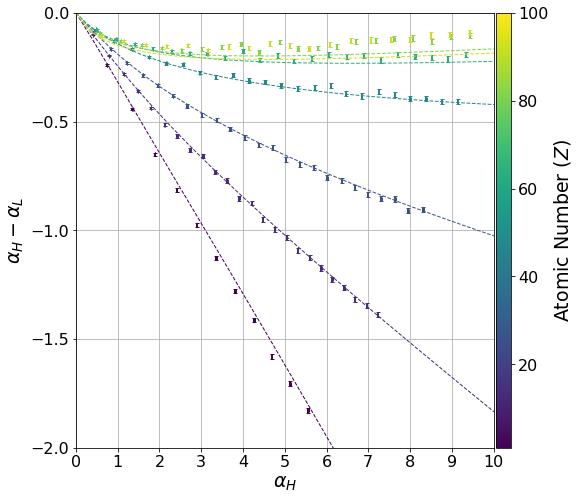

In [6]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L, D, mu_tot, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, phi_H, D, mu_tot, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, phi_L, D, mu_tot, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_freestreaming.png", bbox_inches = "tight")

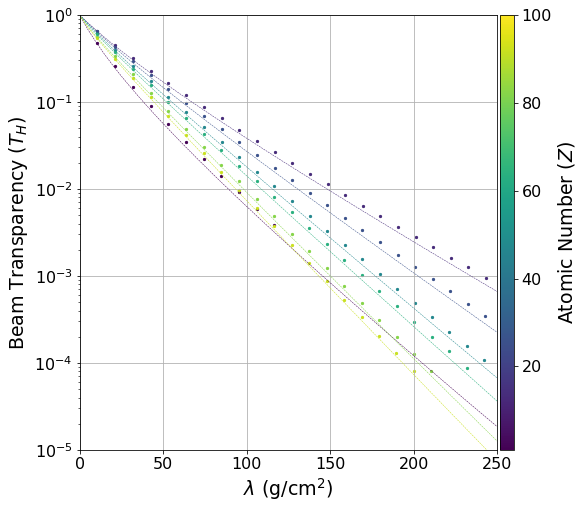

In [7]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    ax.scatter(lmbda_H, np.exp(-alpha_H), s=5, color = color(Z))
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_tot, zRange)
    ax.plot(lmbdaRange, np.exp(-alpha_H0), linewidth = 0.5, linestyle = 'dashed', c=color(Z))

ax.set_xlim([0, 250])
ax.set_ylim([1e-5, 1])
ax.semilogy()
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\lambda$ (g/cm${}^2$)", fontsize=19)
ax.set_ylabel(r"Beam Transparency ($T_H$)", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "T_H_lambda_freestreaming.png", bbox_inches = "tight")

### Z of best fit

True Z: 1; Fit Z: [1]; Loss: [0.00051632]
True Z: 6; Fit Z: [6]; Loss: [0.00011041]
True Z: 13; Fit Z: [13]; Loss: [5.93557485e-05]
True Z: 20; Fit Z: [20]; Loss: [6.91127293e-05]
True Z: 26; Fit Z: [26]; Loss: [5.76108027e-05]
True Z: 32; Fit Z: [32]; Loss: [6.52563887e-05]
True Z: 40; Fit Z: [40]; Loss: [8.86703536e-05]
True Z: 47; Fit Z: [48]; Loss: [4.33057443e-05]
True Z: 55; Fit Z: [58]; Loss: [3.87542738e-05]
True Z: 64; Fit Z: [70 89]; Loss: [6.17966087e-05 1.31401066e-04]
True Z: 74; Fit Z: [80]; Loss: [0.00063676]
True Z: 82; Fit Z: [80]; Loss: [0.00098268]
True Z: 92; Fit Z: [80]; Loss: [0.0012621]


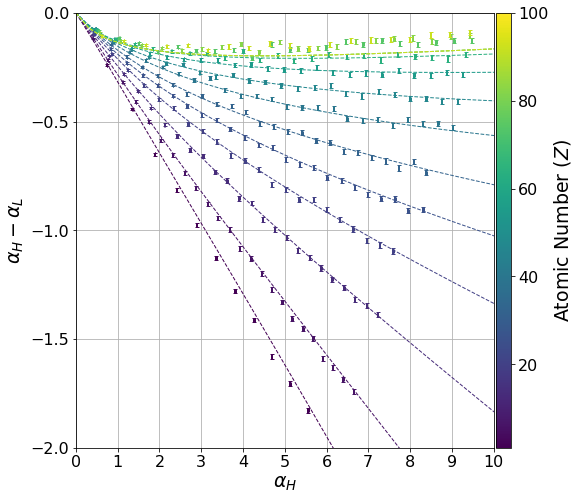

In [8]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, phi_H, phi_L, D, mu_tot, mu_tot, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_H, D, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_L, D, mu_tot, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Semiempirical mass attenuation coefficient

Minimum found at a = 1.1148, b=0.9600, c=0.9994 with a loss of 1.495e-11
Minimum found at a = 0.9453, b=0.9680, c=0.9980 with a loss of 5.569e-12
Bias_H = 0.0135
Bias_L = 0.012


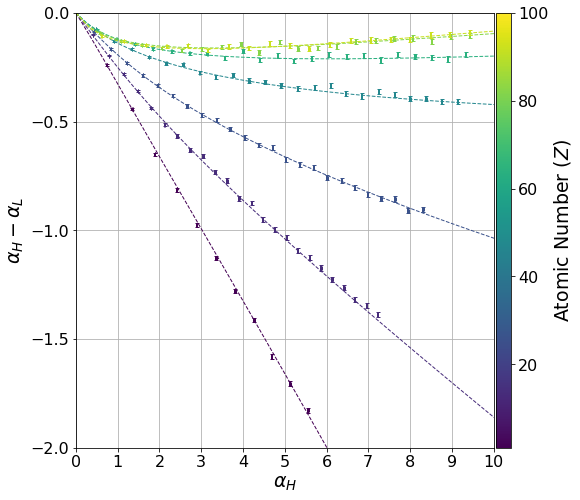

In [9]:
a_H, b_H, c_H = fitSemiempirical(alpha_H_calib, lmbda_H_calib, Z_arr_calib, phi_H, D, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
a_L, b_L, c_L = fitSemiempirical(alpha_L_calib, lmbda_L_calib, Z_arr_calib, phi_L, D, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
mu_H = mu_tot + (a_H-1)*mu_PE + (b_H-1)*mu_CS + (c_H-1)*mu_PP
mu_L = mu_tot + (a_L-1)*mu_PE + (b_L-1)*mu_CS + (c_L-1)*mu_PP

fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L, D, mu_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

    
bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, phi_H, D, mu_H, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, phi_L, D, mu_L, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_semiempirical.png", bbox_inches = "tight")

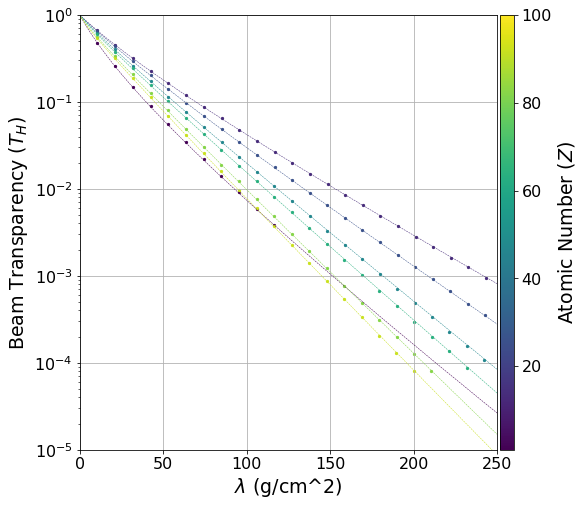

In [10]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    #ax.errorbar(lmbda_H, alpha_H, yerr = sigma_H, 
    #             elinewidth=2, capsize=1, ecolor = color(Z), ls='none')
    ax.scatter(lmbda_H, np.exp(-alpha_H), s=5, color = color(Z))
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H, D, mu_H, zRange)
    ax.plot(lmbdaRange, np.exp(-alpha_H0), linewidth = 0.5, linestyle = 'dashed', c=color(Z))

ax.set_xlim([0, 250])
ax.set_ylim([1e-5, 1])
ax.semilogy()
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\lambda$ (g/cm^2)", fontsize=19)
ax.set_ylabel(r"Beam Transparency ($T_H$)", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "T_H_lambda_semiempirical.png", bbox_inches = "tight")

### Z of best fit using semiempirical parameters

True Z: 1; Fit Z: [1]; Loss: [8.35496262e-05]
True Z: 6; Fit Z: [6]; Loss: [6.46793825e-05]
True Z: 13; Fit Z: [13]; Loss: [8.50546182e-05]
True Z: 20; Fit Z: [20]; Loss: [7.54832618e-05]
True Z: 26; Fit Z: [26]; Loss: [3.69598173e-05]
True Z: 32; Fit Z: [32]; Loss: [6.99683292e-05]
True Z: 40; Fit Z: [41]; Loss: [8.55766716e-05]
True Z: 47; Fit Z: [48]; Loss: [4.87203938e-05]
True Z: 55; Fit Z: [56]; Loss: [3.06978158e-05]
True Z: 64; Fit Z: [65]; Loss: [4.83182212e-05]
True Z: 74; Fit Z: [76 99]; Loss: [9.71985219e-05 1.23561432e-04]
True Z: 82; Fit Z: [81 95]; Loss: [6.51801581e-05 7.14748587e-05]


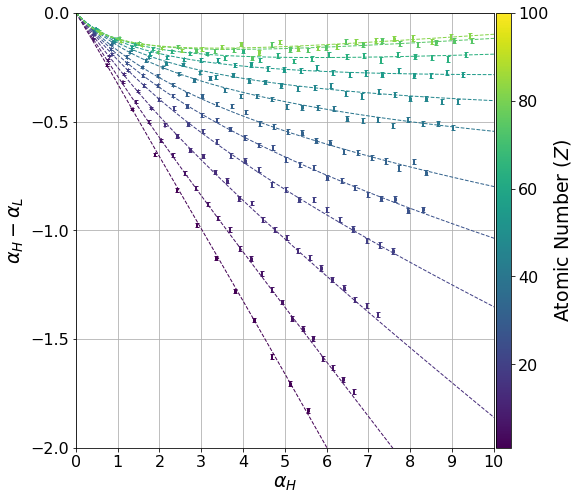

In [11]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[:-1]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
    
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, phi_H, phi_L, D, mu_H, mu_L, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_H, D, mu_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_L, D, mu_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Mismatched parameters, free streaming

Bias_H = 0.059
Bias_L = 0.0599


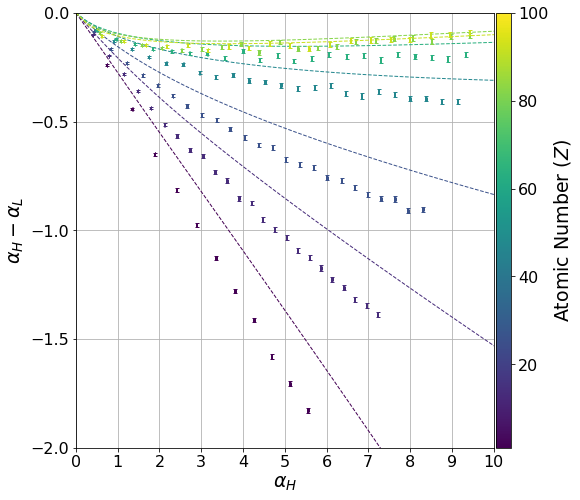

In [12]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H_twiddle, D_twiddle, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L_twiddle, D_twiddle, mu_tot, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, phi_H_twiddle, D_twiddle, mu_tot, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, phi_L_twiddle, D_twiddle, mu_tot, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_freestreaming_mismatched.png", bbox_inches = "tight")

True Z: 1; Fit Z: [1]; Loss: [0.01754589]
True Z: 6; Fit Z: [2]; Loss: [0.00039641]
True Z: 13; Fit Z: [8]; Loss: [0.00025372]
True Z: 20; Fit Z: [15]; Loss: [0.0001907]
True Z: 26; Fit Z: [20]; Loss: [0.00020323]
True Z: 32; Fit Z: [26]; Loss: [0.00012363]
True Z: 40; Fit Z: [34]; Loss: [0.00018533]
True Z: 47; Fit Z: [40]; Loss: [0.00012672]
True Z: 55; Fit Z: [48]; Loss: [0.0001341]
True Z: 64; Fit Z: [55]; Loss: [0.00013971]
True Z: 74; Fit Z: [64 99]; Loss: [0.00027769 0.00014444]
True Z: 82; Fit Z: [66 96]; Loss: [0.00025797 0.00012779]
True Z: 92; Fit Z: [69 94]; Loss: [0.00022432 0.00010859]


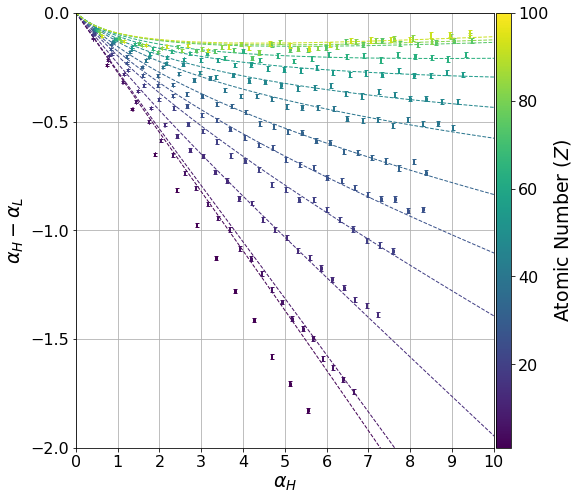

In [13]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, phi_H_twiddle, phi_L_twiddle, D_twiddle, mu_tot, mu_tot, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_H_twiddle, D_twiddle, mu_tot, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_L_twiddle, D_twiddle, mu_tot, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Mismatched parameters, semiempirical

Minimum found at a = 1.0662, b=0.9792, c=1.0028 with a loss of 1.637e-12
Minimum found at a = 1.1271, b=1.0345, c=0.9078 with a loss of 1.483e-12
Bias_H = 0.0126
Bias_L = 0.0127


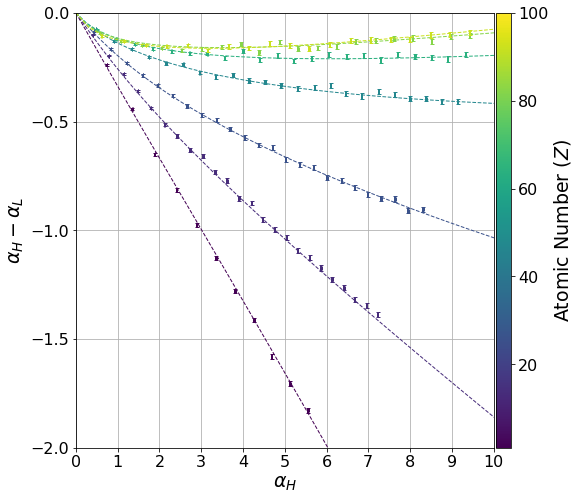

In [14]:
fig, ax = plt.subplots(1, figsize = [8, 8])

a_H, b_H, c_H = fitSemiempirical(alpha_H_calib, lmbda_H_calib, Z_arr_calib, phi_H_twiddle, D_twiddle, mu_tot, mu_PE, mu_CS, mu_PP, zRange)
a_L, b_L, c_L = fitSemiempirical(alpha_L_calib, lmbda_L_calib, Z_arr_calib, phi_L_twiddle, D_twiddle, mu_tot, mu_PE, mu_CS, mu_PP, zRange)

mu_H = mu_tot + (a_H-1)*mu_PE + (b_H-1)*mu_CS + (c_H-1)*mu_PP
mu_L = mu_tot + (a_L-1)*mu_PE + (b_L-1)*mu_CS + (c_L-1)*mu_PP

for Z in Z_plot:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], phi_H_twiddle, D_twiddle, mu_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], phi_L_twiddle, D_twiddle, mu_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, phi_H_twiddle, D_twiddle, mu_H, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, phi_L_twiddle, D_twiddle, mu_L, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_semiempirical_mismatched.png", bbox_inches = "tight")

True Z: 1; Fit Z: [1]; Loss: [6.82433158e-05]
True Z: 6; Fit Z: [6]; Loss: [7.40493656e-05]
True Z: 13; Fit Z: [13]; Loss: [9.33076205e-05]
True Z: 20; Fit Z: [20]; Loss: [8.17824299e-05]
True Z: 26; Fit Z: [26]; Loss: [3.88986976e-05]
True Z: 32; Fit Z: [32]; Loss: [7.01213043e-05]
True Z: 40; Fit Z: [40]; Loss: [8.97798376e-05]
True Z: 47; Fit Z: [47]; Loss: [4.80590914e-05]
True Z: 55; Fit Z: [56]; Loss: [3.27221766e-05]
True Z: 64; Fit Z: [65]; Loss: [5.18154691e-05]
True Z: 74; Fit Z: [ 76 100]; Loss: [0.00010708 0.00014693]
True Z: 82; Fit Z: [80 96]; Loss: [7.27579004e-05 8.15414095e-05]
True Z: 92; Fit Z: [86 90]; Loss: [3.11405374e-05 3.21597329e-05]


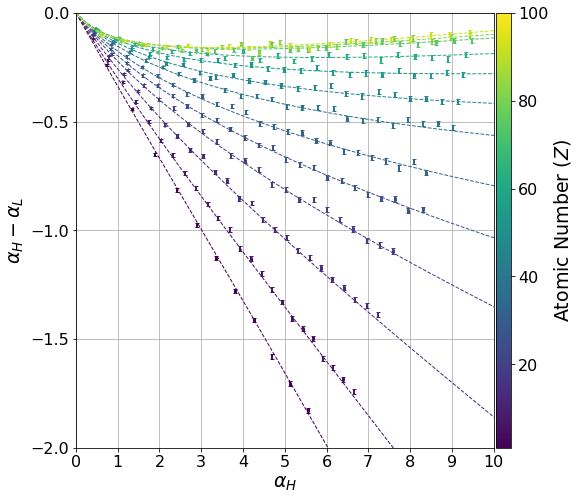

In [15]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, phi_H_twiddle, phi_L_twiddle, D_twiddle, mu_H, mu_L, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_H_twiddle, D_twiddle, mu_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], phi_L_twiddle, D_twiddle, mu_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H$", fontsize=19)
ax.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel(r"Atomic Number ($Z$)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Compound Materials

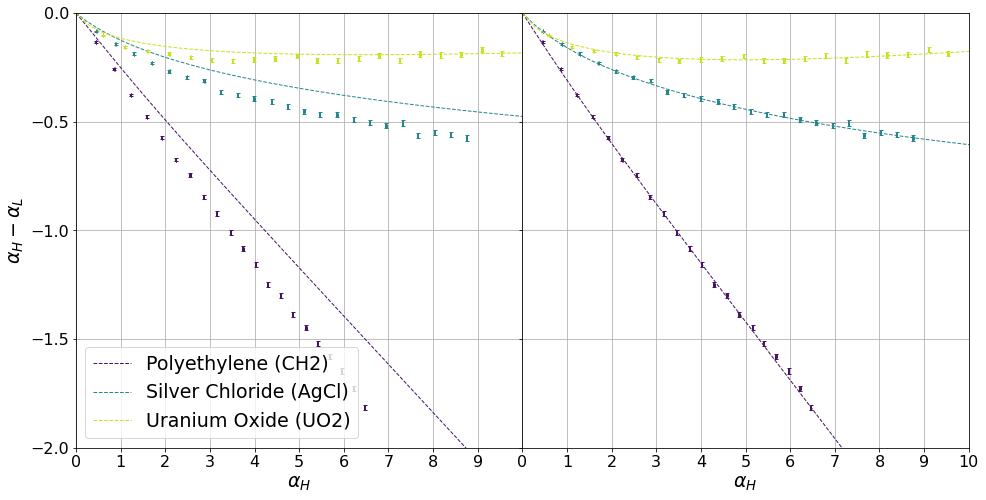

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [16, 8], sharey = True)
fig.subplots_adjust(wspace=0)

for Z in Z_compound:        
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax1.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = compound_c[Z], ls='none')
    ax2.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = compound_c[Z], ls='none') 
        
    ### plot against theory
    alpha_H0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], phi_H_twiddle, D_twiddle, mu_tot, zRange) for lmbda in lmbdaRange])
    alpha_L0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], phi_L_twiddle, D_twiddle, mu_tot, zRange) for lmbda in lmbdaRange])
    ax1.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', color = compound_c[Z], label = compound_material[Z])
    
    alpha_H0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], phi_H_twiddle, D_twiddle, mu_H, zRange) for lmbda in lmbdaRange])
    alpha_L0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], phi_L_twiddle, D_twiddle, mu_L, zRange) for lmbda in lmbdaRange])
    ax2.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', color = compound_c[Z], label = compound_material[Z])
    
ax1.set_xlim(xrange)
ax2.set_xlim(xrange)
ax1.set_ylim(yrange)
ax1.set_xticks(xticks[:-1])
ax2.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax1.set_xlabel(r"$\alpha_H$", fontsize=19)
ax2.set_xlabel(r"$\alpha_H$", fontsize=19)
ax1.set_ylabel(r"$\alpha_H - \alpha_L$", fontsize=19)
ax1.legend(fontsize=19)

plt.savefig(outfile + "alpha_curve_compound.png", bbox_inches = "tight")

### Debug

In [17]:
def readDat(filename):
    """Calculates the total energy deposited (and uncertainty) for filename"""
    line_number = 2 #skip header
    with open(filename) as f:
        header = np.array(f.readline().split())
        E_beam_idx = np.argmax(header == "E_beam(MeV)")
        E_incident_idx = np.argmax(header == "E_incident(MeV)")
        creator_process_idx = np.argmax(header == "CreatorProcessName")
        particle_name_idx = np.argmax(header == "ParticleName")
        for line in f:
            entries = line.split()
            E_beam = entries[E_beam_idx]
            E_incident = entries[E_incident_idx]
            creator_process = entries[creator_process_idx]
            particle_name = entries[particle_name_idx]
                           
            if creator_process != "EventGenerator":
                print("creator_process = %s; line %d" % (creator_process, line_number))
                
            elif E_beam != E_incident:
                print("Compton scatter: line %d" % line_number)
 
            line_number += 1
    
readDat("/Users/peter/Work/semiempirical_transparency/src/debug/E=10MeV-lmbda=100-Z=26-N=1000000.dat")

Compton scatter: line 45
Compton scatter: line 86
creator_process = conv; line 232
creator_process = annihil; line 233
Compton scatter: line 262
creator_process = compt; line 496
creator_process = eBrem; line 500
Compton scatter: line 501
Compton scatter: line 517
Compton scatter: line 546
creator_process = compt; line 645
creator_process = eBrem; line 869
creator_process = eBrem; line 900
Compton scatter: line 968
Compton scatter: line 1017
creator_process = phot; line 1041
Compton scatter: line 1114
Compton scatter: line 1133
Compton scatter: line 1151
creator_process = compt; line 1186
Compton scatter: line 1265
creator_process = compt; line 1372
Compton scatter: line 1406
Compton scatter: line 1445
creator_process = compt; line 1687
Compton scatter: line 1703
creator_process = annihil; line 1815
Compton scatter: line 2106
creator_process = annihil; line 2119
creator_process = annihil; line 2126
creator_process = compt; line 2174
Compton scatter: line 2180
creator_process = compt; l